In [1]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Visualizaciones
# -----------------------------------------------------------------------
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Funciones
import sys
sys.path.append('src') #pongo los 2 puntos para que salga de la carpeta
import src.funciones as f
import src.soporte_prep as spp


# Analisis Exploratorio Series Temporales
# -----------------------------------------------------------------------
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# Modelo Series Temporales
# -----------------------------------------------------------------------
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from itertools import product


# Otros
# -----------------------------------------------------------------------
from tqdm import tqdm

In [2]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'

In [3]:
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')
df.index.name = 'Date'
df.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
df.dtypes

Passengers    int64
dtype: object

In [5]:
df_copia= df.copy()
df_copia['Month'] = df_copia.index.month_name() # no hace falta pasarle el dt de formato fecha
df_copia['Year'] = df_copia.index.year
df_copia.head()

,Passengers,Month,Year
Date,,,
1949-01-01,112,January,1949
1949-02-01,118,February,1949
1949-03-01,132,March,1949
1949-04-01,129,April,1949
1949-05-01,121,May,1949


In [6]:
spp.exploracion_datos(df_copia)

El número de filas es 144 y el número de columnas es 3

----------

En este conjunto de datos tenemos 0 valores duplicados

----------

Los columnas con valores nulos y sus porcentajes son: 


Series([], dtype: float64)


----------

Las principales estadísticas de las variables númericas son:


,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.00,265.5,360.50,622.0
Year,144.0,1954.500000,3.464102,1949.0,1951.75,1954.5,1957.25,1960.0



----------

Las principales estadísticas de las variables categóricas son:


,count,unique,top,freq
Month,144,12,January,12



----------

Las características principales del dataframe son:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Passengers  144 non-null    int64 
 1   Month       144 non-null    object
 2   Year        144 non-null    int32 
dtypes: int32(1), int64(1), object(1)
memory usage: 3.9+ KB


None

In [7]:
df_copia = df_copia.asfreq('MS') # asigno frecuencia mes 'MS' es porque es objeto de pandas

In [8]:
df_copia.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Date', length=144, freq='MS')

In [9]:
fecha_completa = pd.date_range(start=df_copia.index.min(), end=df_copia.index.max(), freq='MS') # creo una secuencia de datos 
mes_anio_completo = fecha_completa.to_period('M') #ponerle la M para que no me dé el día, M es porque es atributo
mes_anio_completo

PeriodIndex(['1949-01', '1949-02', '1949-03', '1949-04', '1949-05', '1949-06',
             '1949-07', '1949-08', '1949-09', '1949-10',
             ...
             '1960-03', '1960-04', '1960-05', '1960-06', '1960-07', '1960-08',
             '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', length=144)

In [10]:
mes_anio_actual = df_copia.index.to_period('M') #convierto mis datos al mismo formato
mes_anio_actual

PeriodIndex(['1949-01', '1949-02', '1949-03', '1949-04', '1949-05', '1949-06',
             '1949-07', '1949-08', '1949-09', '1949-10',
             ...
             '1960-03', '1960-04', '1960-05', '1960-06', '1960-07', '1960-08',
             '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]', name='Date', length=144)

In [11]:
mes_anio_completo.difference(mes_anio_actual) # no hay diferencias

PeriodIndex([], dtype='period[M]')

In [12]:
df.sort_index(inplace=True) # asi me aseguro que esté todo ordenado

<Axes: xlabel='Date', ylabel='Passengers'>

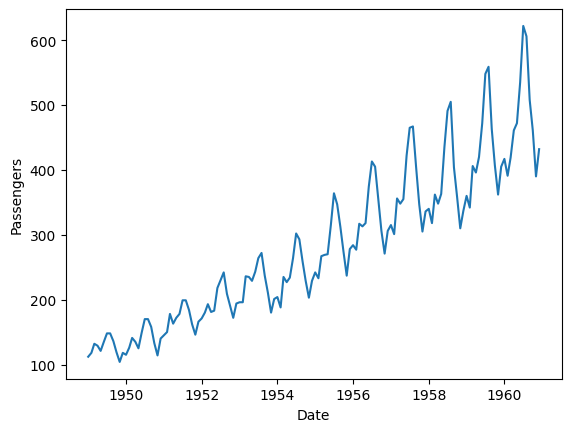

In [13]:
sns.lineplot(x=df_copia.index,
             y=df_copia['Passengers'])

Tendencia, no son estacionarios
Se puede ver picos 

<Axes: xlabel='Month', ylabel='Passengers'>

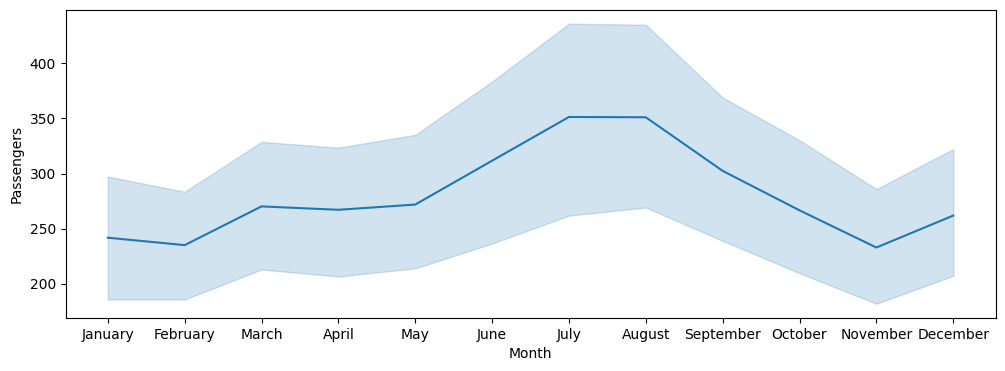

In [14]:
plt.figure(figsize=(12,4))
sns.lineplot(x=df_copia['Month'], 
             y=df_copia['Passengers'])

Aquí veo las medias, pero no lo tengo individual

<Axes: xlabel='Month', ylabel='Passengers'>

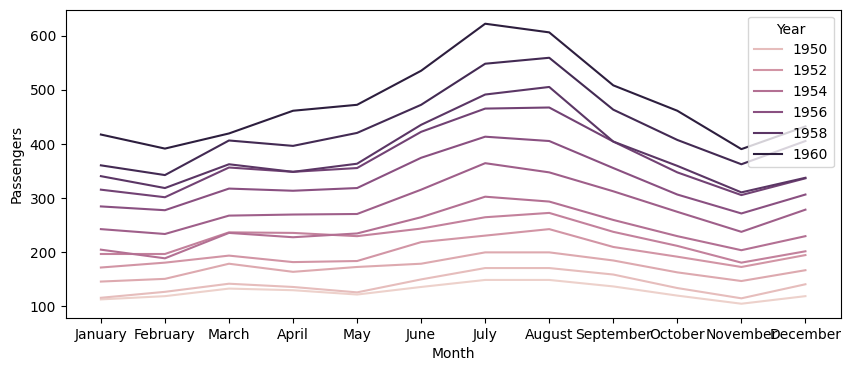

In [15]:
plt.figure(figsize=(10,4))
sns.lineplot(x=df_copia['Month'], 
             y=df_copia['Passengers'],
             hue=df_copia['Year'])

Aqui tenemos tendencias y estacionalidad

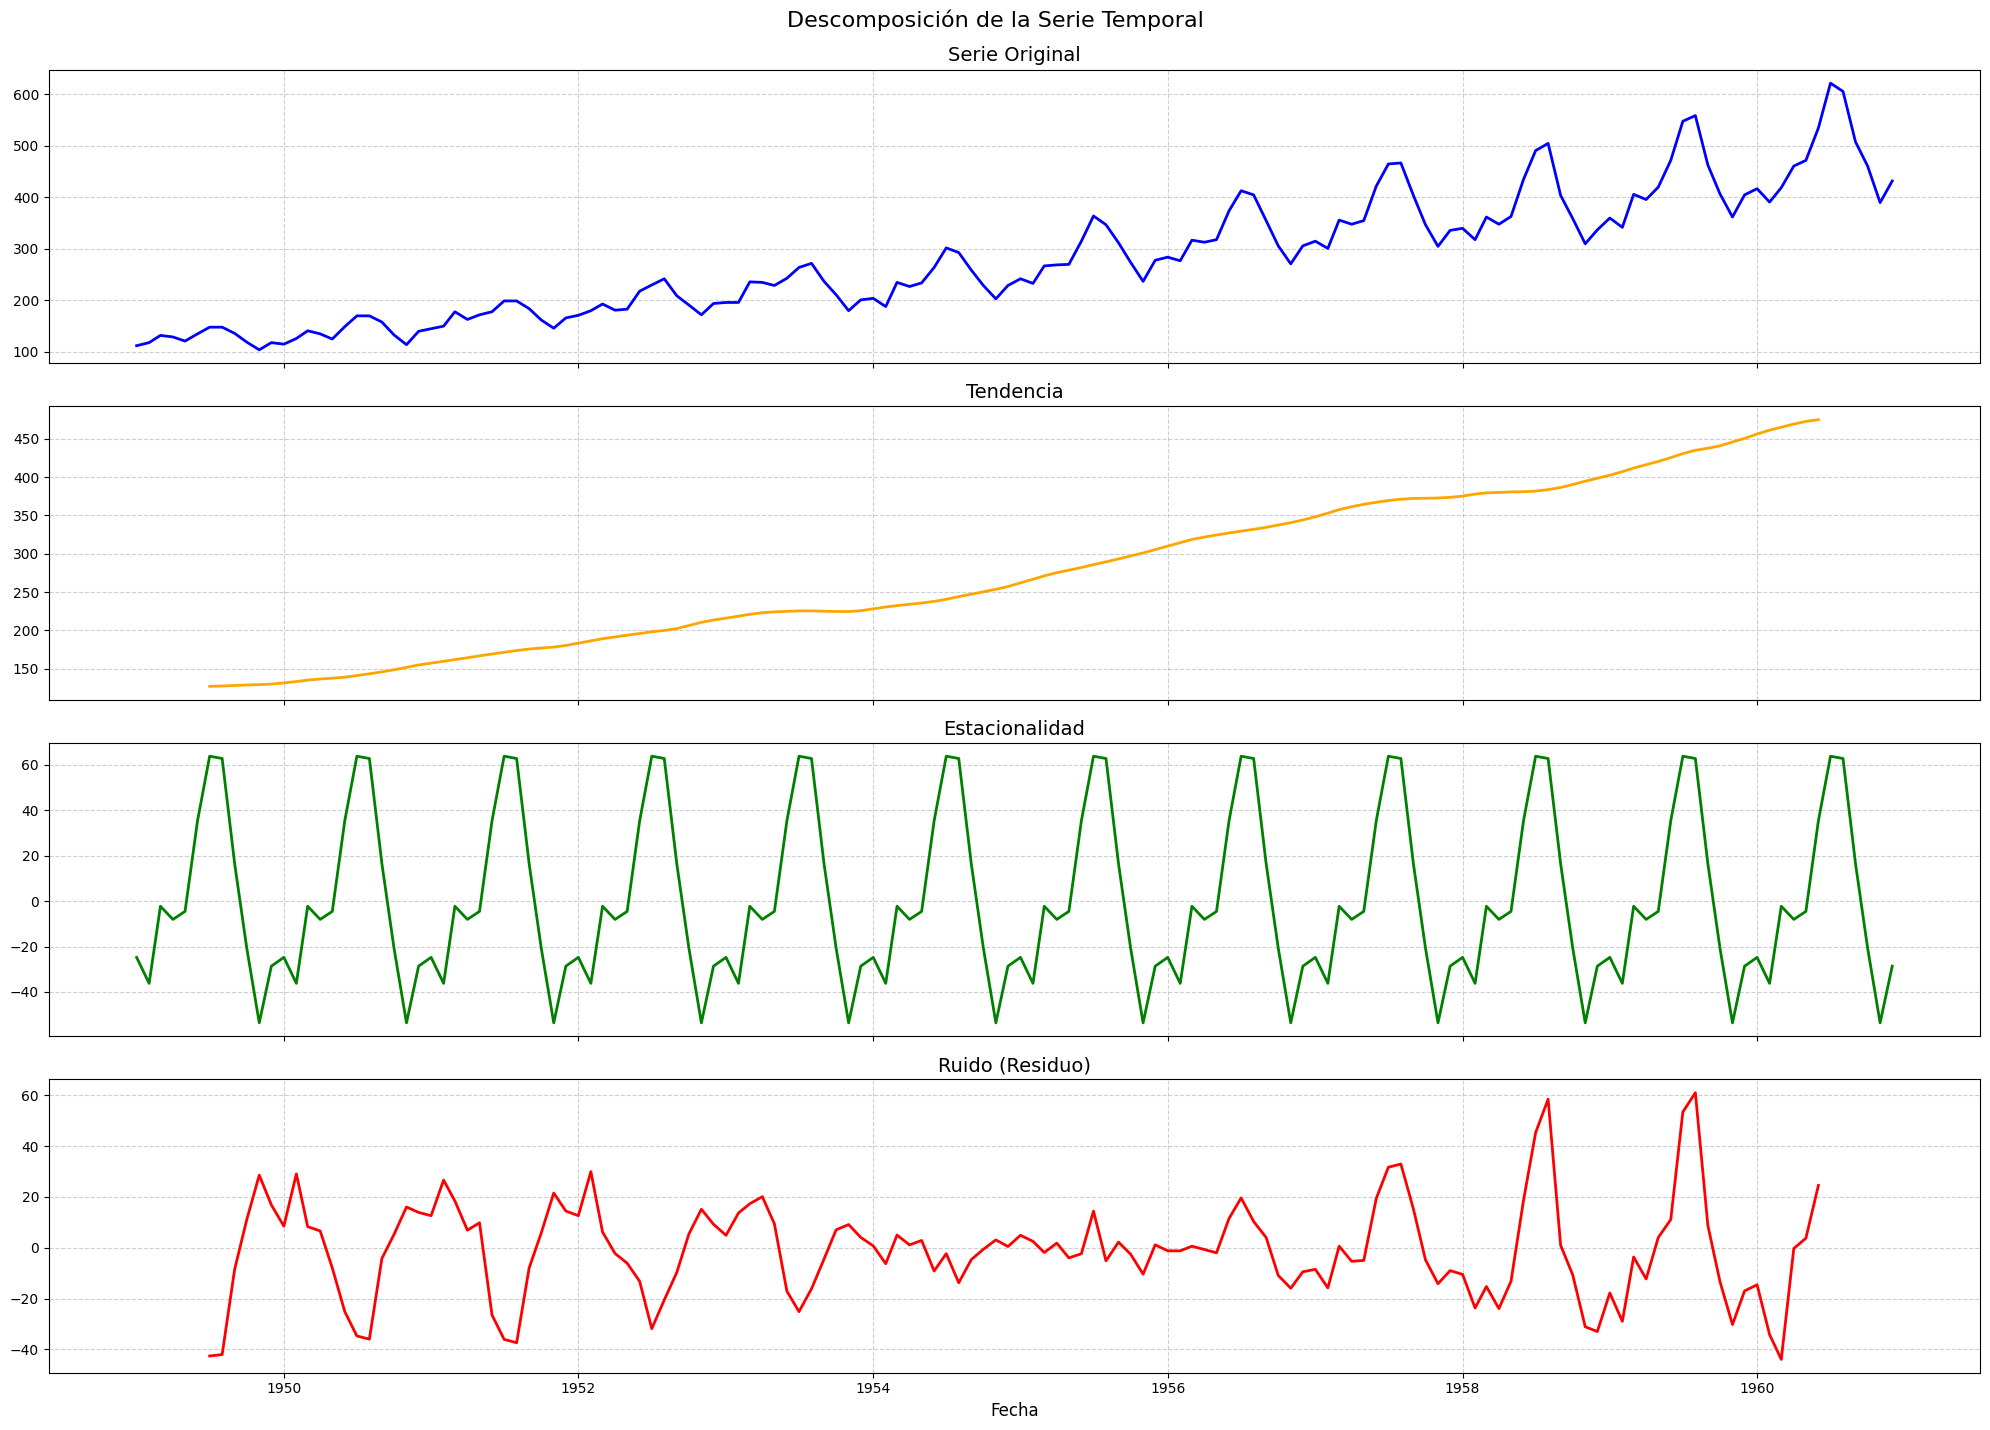

In [16]:
decomposition = seasonal_decompose(df["Passengers"], model='additive', period=12)

# Crear figura y subplots
fig, axes = plt.subplots(4, 1, figsize= (20, 15), sharex=True)

# Serie original
axes[0].plot(df["Passengers"], color="blue", linewidth=2)
axes[0].set_title("Serie Original", fontsize=14)
axes[0].grid(visible=True, linestyle="--", alpha=0.6)

# Tendencia
axes[1].plot(decomposition.trend, color="orange", linewidth=2)
axes[1].set_title("Tendencia", fontsize=14)
axes[1].grid(visible=True, linestyle="--", alpha=0.6)

# Estacionalidad
axes[2].plot(decomposition.seasonal, color="green", linewidth=2)
axes[2].set_title("Estacionalidad", fontsize=14)
axes[2].grid(visible=True, linestyle="--", alpha=0.6)

# Ruido
axes[3].plot(decomposition.resid, color="red", linewidth=2)
axes[3].set_title("Ruido (Residuo)", fontsize=14)
axes[3].grid(visible=True, linestyle="--", alpha=0.6)

# Ajustar diseño
plt.suptitle("Descomposición de la Serie Temporal", fontsize=16, y=0.95)
plt.xlabel("Fecha", fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Métricas en general para ver

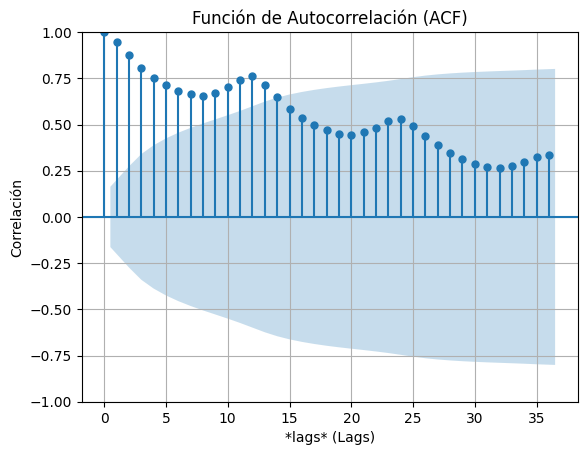

In [17]:
# GRAFICO DE LA AUTOCORRELACIÓN
plot_acf(df, lags=36)  
plt.title("Función de Autocorrelación (ACF)")
plt.xlabel("*lags* (Lags)")
plt.ylabel("Correlación")
plt.grid();

De aquí tomo el error, q = 14

LA sombra es el intervalo de confianza, debajo de él la correlacion no es significativa

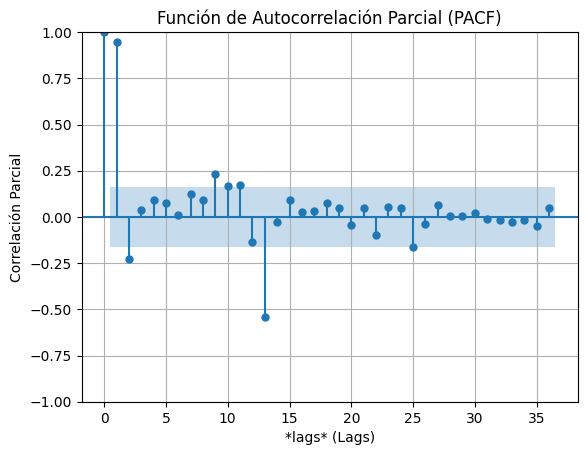

In [18]:
# Graficar la autocorrelación parcial
plot_pacf(df, lags=36, method='ywm')  # Cambia 'method' según tu versión
plt.title("Función de Autocorrelación Parcial (PACF)")
plt.xlabel("*lags* (Lags)")
plt.ylabel("Correlación Parcial")
plt.grid()
plt.show()

De aquí saco p=2

In [19]:
datos_test = int(df.shape[0] * 0.2)

In [20]:
y_train = df.iloc[:-datos_test]
y_test = df.iloc[-datos_test:]

In [21]:
ps= range(4)
qs = range(11)

combinaciones = list(product(ps,qs)) # hago mis combinaciones
combinaciones[:3]

[(0, 0), (0, 1), (0, 2)]

In [22]:
resultados = {'q': [], 'p': [], 'rmse': []}
for p,q in combinaciones:
    modelo_sarima = SARIMAX(
        y_train,
        order = (p, 1, q), #p-d-q
        seasonal_order= (1,1,1,12) # p-d-q-S
    ).fit()

    pred_y_test = modelo_sarima.predict(start=len(y_train), end=len(df)-1) # desde el final del ytrain a el final del df original

    rmse = np.sqrt(mean_squared_error(pred_y_test, y_test))
    resultados['p'].append(p)
    resultados['q'].append(q)
    resultados['rmse'].append(rmse)

pd.DataFrame(resultados).sort_values(by='rmse', ascending=True)

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCach

,q,p,rmse
1,1,0,23.032895
11,0,1,23.058497
33,0,3,23.096850
12,1,1,23.393451
35,2,3,23.449957
23,1,2,23.825519
22,0,2,24.066116
13,2,1,24.231923
2,2,0,24.473923
36,3,3,24.508147


In [29]:
modelo_sarima_2 = SARIMAX(
    y_train,
    order = (1, 1, 1), #p-d-q
    seasonal_order= (1,1,1,12) # p-d-q-S
).fit()

pred_y_test = modelo_sarima.predict(start=len(y_train), end=len(df)-1) # desde el final del ytrain a el final del df original


y_test['predichos'] = pred_y_test.astype(int)
y_test

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\DELL\AppData\Local\Temp\ipykernel_26228\91831365.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['predichos'] = pred_y_test.astype(in

,Passengers,predichos
Date,,
1958-09-01,404,441
1958-10-01,359,386
1958-11-01,310,344
1958-12-01,337,376
1959-01-01,360,380
1959-02-01,342,359
1959-03-01,406,405
1959-04-01,396,391
1959-05-01,420,405


<Axes: xlabel='Date', ylabel='Passengers'>

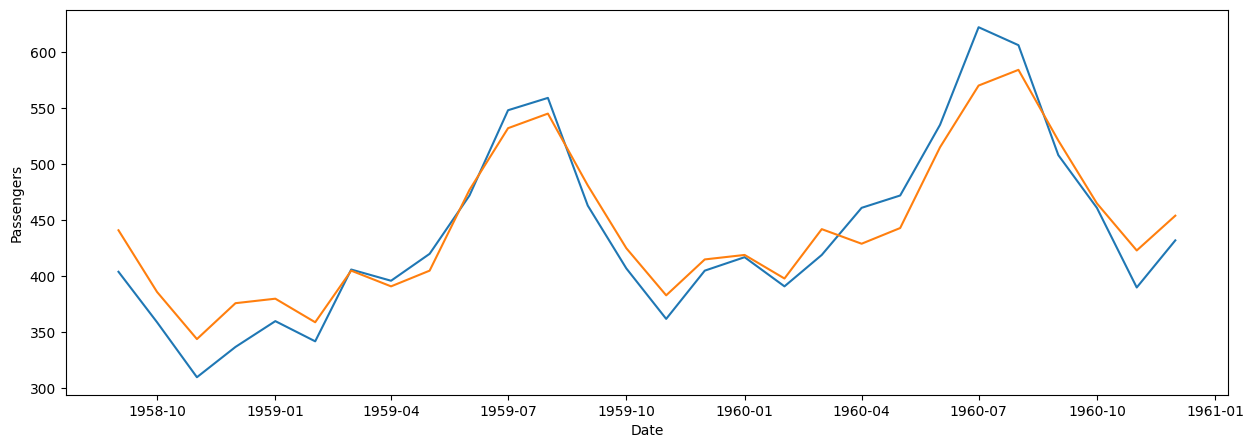

In [30]:
plt.figure(figsize=(15,5))

sns.lineplot(x=y_test.index, y='Passengers', data=y_test)
sns.lineplot(x=y_test.index, y='predichos', data=y_test)
